# Decision Trees
**Decision Trees (DTs)** are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision trees learn from data to approximate an underlying target function with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

The scikit-learn documentation on [Decision Trees](http://scikit-learn.org/stable/modules/tree.html) has some excellent basic examples for both classification and regression.

## Advantages of Decision Trees
* Simple to understand and to interpret. Trees can be visualised.
* Requires little data preparation. Other techniques often require data normalization.  
    * Note however that generally missing values either need to be imputed or removed and categorical features typically need to be encoded as an enum, but this is true for pretty much all machine learning algorithms.
* The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.  So they are generally fast to train.

## Disadvantages of Decision Trees
* Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning (not currently supported by scikit-learn), setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
    * Overfitting is a much bigger problem for Decision Trees than for many other algorithms and because of this Decision Trees are almost never used in the real world outside of an ensemble, such as with Random Forests.  
* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
* The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

*Disclaimer*: Some of the code in this notebook was lifted from the excellent book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) by Andreas Muller and Sarah Guido.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### A First Application: Classifying iris species
One of the most famous datasets for classification in a supervised learning setting is the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set).  It is a multivariate dataset introduced in a 1936 paper which records sepal length, sepal width, petal length, and petal width for three species of iris.

scikit-learn has a number of small toy datasets included with it which makes it quick and easy to experiment with different machine learning algorithms on these datasets.

The [sklearn.datasets.load_iris()](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris) method can be used to load the iris dataset.

#### Meet the data
The *iris* object that is returned by **load_iris** is a **Bunch** object, which is very similar to a dictionary.  It contains keys and values.

In [2]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()

In [3]:
print("Keys of iris_dataset: {}".format(iris_dataset.keys()))

Keys of iris_dataset: dict_keys(['target_names', 'data', 'DESCR', 'target', 'feature_names'])


In [4]:
# The value of the key DESCR is a short description of the dataset.  Here we show the beinning of the description.
print(iris_dataset['DESCR'][:193] + "\n...")

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive att
...


In [5]:
# The value of the key target_names is an array of strings, containing the species of flower that we want to predict
print("Target names: {}".format(iris_dataset['target_names']))

Target names: ['setosa' 'versicolor' 'virginica']


In [6]:
# The value of feature_names is a list of strings, giving the description of each feature
print("Feature names: {}".format(iris_dataset['feature_names']))

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [7]:
# The data itself is contained in the target and data fields.
# data contains the numeric measurements of sepal length, sepal width, petal length, and petal width in a NumPy array
print("Type of data: {}".format(type(iris_dataset['data'])))

Type of data: <class 'numpy.ndarray'>


In [8]:
# The rows in the data array correspond to flowers, while the columns represent the four measurements for each flower.
print("Shape of data: {}".format(iris_dataset['data'].shape))

Shape of data: (150, 4)


In [9]:
# We see that the array contains measurements for 150 different flowers (samples).  Here are values for the first 5.
print("First five columns of data:\n{}".format(iris_dataset['data'][:5]))

First five columns of data:
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]


In [10]:
# The target array contains the species of each of the flowers that were measured, also as a NumPy array
print("Type of target: {}".format(type(iris_dataset['target'])))

Type of target: <class 'numpy.ndarray'>


In [11]:
# target is a one-dimensional array, with one entry per flower
print("Shape of target: {}".format(iris_dataset['target'].shape))

Shape of target: (150,)


In [13]:
# The species are encoded as integers from 0 to 2.  The meanings of the numbers are given by the target_names key.
print("Target:\n{}".format(iris_dataset['target']))

Target:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


#### Measuring Success: Training and testing data
We want to build a machine learning model from this data that can predict the species of iris for a new set of measurements.  But before we can apply our model to new measurements, we need to know whether it actually works -- that is, whether we should trust its predictions.

Unfortunately, we cannot use the data we used to build the model to evaluate it.  This is because our model can always simply remember the whole training set, and will therefore always predict the correct label for any point in the training set.  This "remembering" does not indicate to us whether the model will *generalize* well (in other words, whether it will also perform well on new data).

To assess the model's performance, we show it new data (data that it hasn't seen before) for which we have labels.  This is usually done by splitting the labeled data we have collected (here, our 150 flower measurements) into two parts.  One part of the data is used to build our machine learning model, and is called the *training data* or *training set*.  The rest of the data will be used to assess how well the model works; this is called the *test data*, *test set*, or *hold-out set*.

scikit-learn contains a function that shuffles the dataset and splits it for you:  the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.  This function extracts 75% of the rows in the data as the training set, together with the corresponding labels for this data.  The remaining 25% of the data, together with the remaining labels, is declared as the test set.  Deciding how much data you want to put into the training and the test set respectively is somewhat arbitrary, but scikit-learn's default 75/25 split is a reasonable starting point.

In scikit-learn, data is usually denoted with a capital X, while labels are denoted by a lowercase y.  This is inspired by the standard formulation *f(x)=y* in mathematics, where *x* is the input to a function and *y* is the output.  Following more conventions from mathematics, we use a capital *X* because the data is a two-dimensional array (a matrix) and a lowercase *y* because the target is a one-dimensional array (a vector).

Before making the split, the **train_test_split** function shuffles the dataset using a pseudorandom number generator.  If we just took the last 25% of the data as a test set, all the data points would have the label 2, as the data points are sorted by the label.

To make sure this example code will always get the same output if run multiple times, we provide the pseudorandom number generator with a fixed seed using the **random_state** parameter.

The output of the **train_test_split** function is **X_train**, **X_test**, **y_train**, and **y_test**, which are all NumPy arrays.  **X_train** contains 75% of the rows of the dataset, and **X_test** contains the remaining 25%.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_dataset['data'], iris_dataset['target'], random_state=0)

In [16]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (112, 4)
y_train shape: (112,)


In [17]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (38, 4)
y_test shape: (38,)


#### First things first: Look at your data
Before building a machine learning model, it is often a good idea to inspect the data, to see if the task is easily solvable without machine learning, or if the desired information might not be contained in the data.

Additionally, inspecting the data is a good way to find abnormalities and peculiarities.  Maybe some of your irises were measured using inches and not centimeters, for example.  In the real world, inconsistencies in the data and unexpected measurements are very common, as are missing data and not-a-number (NaN) or infinite values.

One of the best ways to inspect data is to visualize it. One way to do this is by using a *scatter plot*.  A scatter plot of the data puts one feature along the x-axis and another along the y-axis, and draws a dot for each data point.  Unfortunately, computer screens have only two dimensions, which allows us to plot only two (or maybe three) features at a time.  It is difficult to plot datasets with more than three features this way.  One way around this problem is to do a *pair plot*, which looks at all possible pairs of features.  If you have a small number of features, such as the four we have here, this is quite reasonable.  You should keep in mind, however, that a pair plot does not show the interaction of all of the features at once, so some interesting aspects of the data may not be revealed when visualizing it this way.

In Python, the *pandas* library has a convenient function called [scatter_matrix](http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html#scatter-matrix-plot) for creating pair plots for a DataFrame.

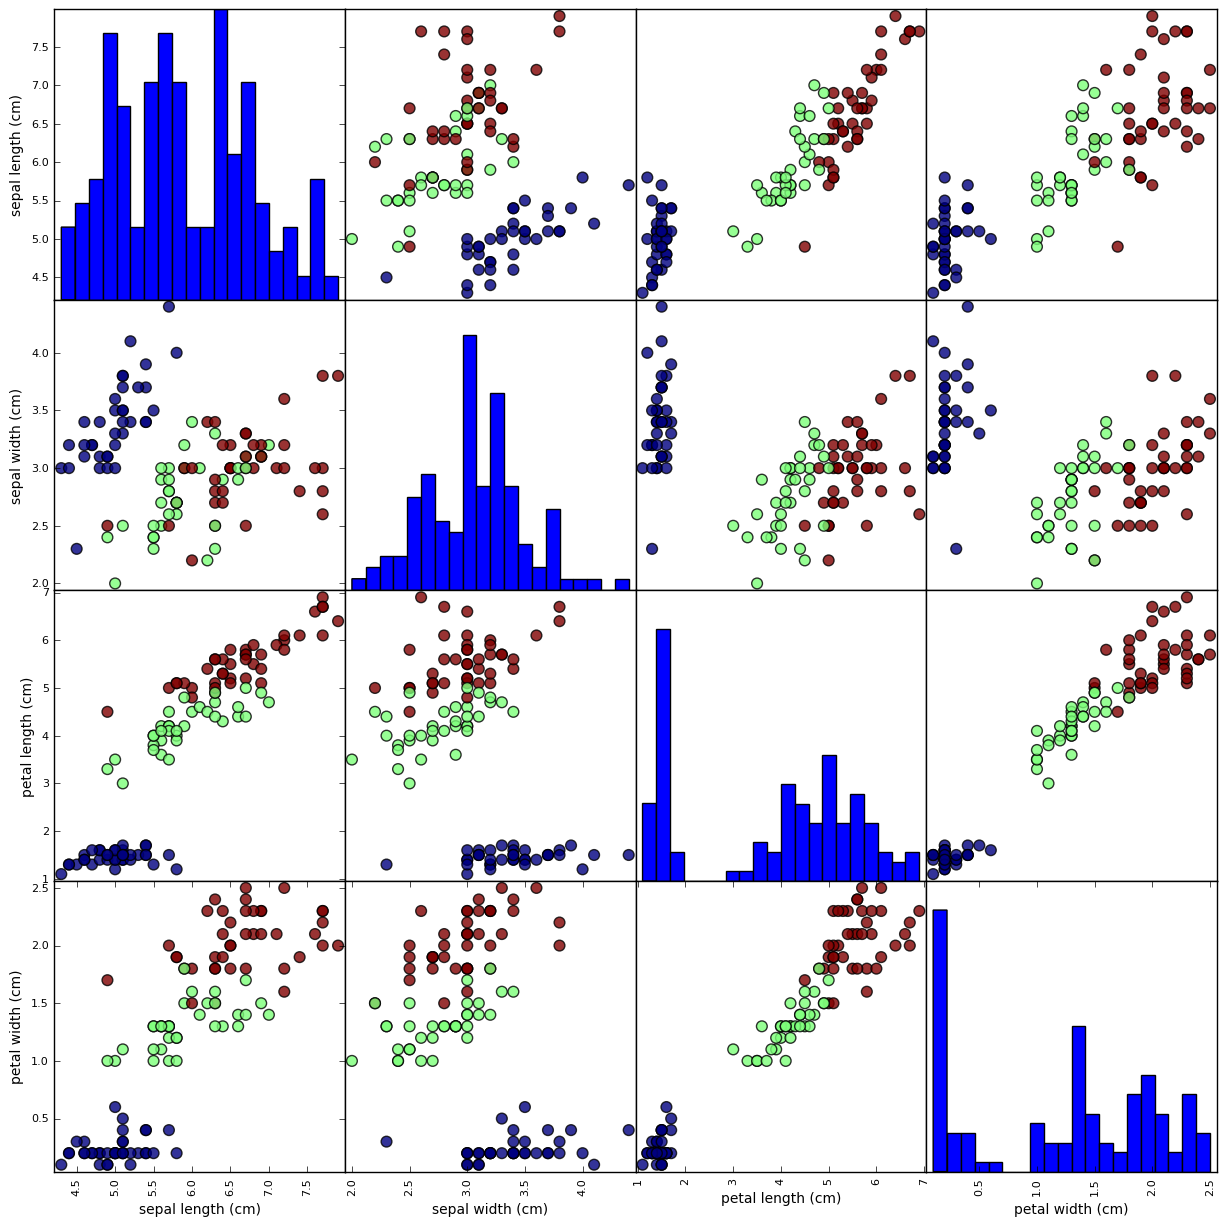

In [21]:
# create dataframe from data in X_train
# label the columns using the strings in iris_dataset.feature_names
iris_dataframe = pd.DataFrame(X_train, columns=iris_dataset.feature_names)
# create a scatter matrix from the dataframe, color by y_train
grr = pd.scatter_matrix(iris_dataframe, c=y_train, figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

From the plots, we can see that the three classes seem to be relatively well separated using the sepal and petal measurements.  This means that a machine learning model will likely be able to learn to separate them quite well.

#### Building your model: Decision Tree
Now we can start building the actual machine learning model.  There are many classification algorithms in *scikit-learn* that we could use.  Here we will use a Decision Tree because it is easy to understand and interpret.

All machine learning models in *scikit-learn* are implemented in their own classes, which are called *Estimator* classes.  The decision tree classification algorithm is implemented in the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) class in the **tree** module.  Before we can use the model, we need to instantiate the class into an object.  This is when we will set any parameters of the model.  The most important parameter of DecisionTreeClassifier is **criterion**, the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain ("gini" is the default).

In [23]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

The *tree* object encapsulates the algorithm that will be used to build the model from the training data, as well the algorithm to make predictions on new data points.  It will also hold the information that the algorithm has extracted from the training data.

To build the model on the training set, we call the **fit** method of the *tree* object, which takes as arguments the NumPy array *X_train* containing the training data and the NumPy array *y_train* of the corresponding training labels.

In [24]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

#### Making predictions
We can now make predictions using this model on new data for which we might not know the correct labels.  Image we found an iris in the wild with a sepal length of 5 cm, a sepal width of 2.9 cm, a petal length of 1 cm, and a petal width of 0.2cm.  What species of iris would this be?  We can put this data into a NumPy array, which in this case will be of shape 1 x 4 (1 row/sample x 4 features).

Note: Even though we made the measurements of this single flower, *scikit-learn* always expects two-dimensional arrays for the data.

To make a prediction, we call the **predict** method of the tree object.

In [41]:
X_new = np.array([[5, 2.9, 1, 0.2]])
print("X_new.shape: {}".format(X_new.shape))

X_new.shape: (1, 4)


In [42]:
prediction = tree.predict(X_new)
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(
       iris_dataset['target_names'][prediction]))

Prediction: [0]
Predicted target name: ['setosa']


#### Evaluating the model
How do we know whether we can trust our model?  This is where the test set that we created earlier comes in.  This data was not used to build the model, but we do know what the correct speciies is for each iris in the test set.

Therefore, we can make a prediction for each iris in the test data and compare it against its lable (the known species).  We can measure how well the model works by computing the *accuracy*, which is the fraction of flowers for which the right species was predicted.

We can also use the **score** method of the tree object, which will compute the test set accuracy for us.

In [43]:
y_pred = tree.predict(X_test)
print("Test set predictions:\n {}".format(y_pred))

Test set predictions:
 [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]


In [44]:
print("Test set score: {:.2f}".format(np.mean(y_pred == y_test)))

Test set score: 0.97


In [45]:
print("Test set score: {:.2f}".format(tree.score(X_test, y_test)))

Test set score: 0.97


For this model, the test set accuracy is about 0.97, which means we made the right prediction for 97% of the irises in the test set.  Under some mathematical assumptions, this means that we can expect our model to be correct about 97% of the time for new irises.  

A more advanced model may be able to do a better job, but with an overlapping dataset like this, it is unlikely that we would ever be able to achieve 100% accuracy.

#### Summary
Here is a summary of the code needed for the whole training and evaluation procedure (just 4 lines!).

This snippet contains the core code for applying any machine learning algorithm using *scikit-learn*.  The **fit**, **predict**, and **score** methods are the common interface to supervised models in *scikit-learn*.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(iris_dataset['data'], iris_dataset['target'], random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

print("Test set score: {:.2f}".format(tree.score(X_test, y_test)))

Test set score: 0.97
